In [ ]:
import numpy as np
from examples import example_defaults
from fna.tasks.symbolic.embeddings import VectorEmbeddings, DynamicEmbeddings

from fna.tasks.symbolic.sequences import SymbolicSequencer
from fna.tasks.symbolic import NonAdjacentDependencies, ArtificialGrammar, NaturalLanguage

------
Preliminary steps:
* Create a few different sequencers to use as an example. 

In [2]:
n_strings = 10
seq_length = 10

In [3]:
random_sequencer = SymbolicSequencer(label='random', set_size=10)
random_sequence = random_sequencer.generate_random_sequence(T=seq_length)

nad_sequencer = NonAdjacentDependencies(vocabulary_size=5, filler_variability=1, dependency_length=4)
nad_sequencer.generate_stringset(set_length=n_strings, generator=False, violations=None)
nad_sequence = nad_sequencer.generate_sequence()

# brown_corp = NaturalLanguage(label="brown", text_data=None, character_level=False)
# brown_seq = brown_corp.sequence

[sequences.py:91 - INFO] Generating symbolic sequencer
[sequences.py:144 - INFO] Generating a random sequence of length 10, from a set of 10 symbols
[sequences.py:91 - INFO] Generating symbolic sequencer
[non_adjacent_dep.py:73 - INFO] Generating 10 strings, according to nAD rules...


* Choose one sequencer to use in the rest of the notebook:

In [4]:
sequencer = random_sequencer
sequence = random_sequence

* Create a few different embeddings as examples

In [5]:
# vector / scalar embeddings
scalar = VectorEmbeddings(vocabulary=sequencer.tokens).real_valued(dim=1, distribution=np.random.uniform, parameters={
    'low': -1., 'high': 1.})

one_hot = VectorEmbeddings(vocabulary=sequencer.tokens).one_hot()

binary_codeword = VectorEmbeddings(vocabulary=sequencer.tokens).binary_codeword(dim=100, density=0.1)

random_vector1 = VectorEmbeddings(vocabulary=sequencer.tokens).real_valued(dim=None, distribution=np.random.uniform, parameters={
     'low': 0., 'high': 1.})

random_vector2 = VectorEmbeddings(vocabulary=sequencer.tokens).real_valued(dim=1000, distribution=np.random.normal,
                                                                    parameters={'loc': 0., 'scale': 0.5})

* Choose one embedding to use in the rest of the notebook and generate discrete stimulus sequence:

[embeddings.py:216 - INFO] Generating stimulus sequence: 10 symbols
[embeddings.py:216 - INFO] Generating stimulus sequence: 10 symbols


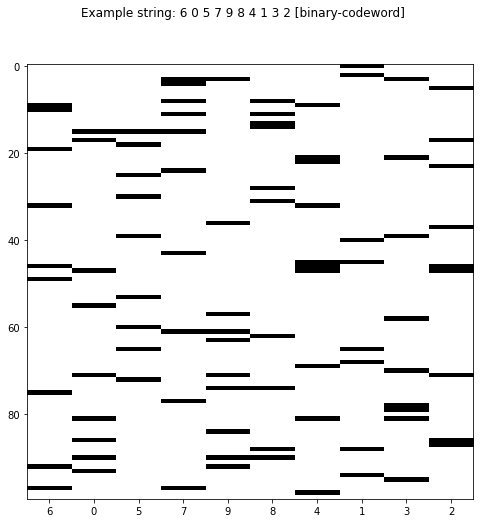

In [6]:
emb = binary_codeword
discrete_stim_seq = emb.draw_stimulus_sequence(sequence, as_array=True)

emb.plot_sample(sequence[:10], save=False)

**Note:** This discrete stimulus sequences is the input to be used in networks operating in discrete time. So, if the target network is discrete, the subsequent steps are not relevant.

* Generate continuous input - for continuous systems, we need to unfold the stimulus representations in time (see [embeddings](embeddings.ipynb#section2.2)), or, alternatively, convert each token to a unique spatiotemoral spike pattern (see [embeddings](embeddings.ipynb#section2.3)).

In [7]:
continuous = True # generate a continuous stimulus sequence or iterate

In [8]:
# ################################
# input from embedding
# ######
# a) unfold embedding to continuous signal
signal_pars = {
    'duration': 250., # single values or rvs
    'amplitude': 100., # single value, list of dim, or rvs
    'kernel': ('box', {}), # (kernel_label, {parameters}).. see documentation
    'dt': 0.1 # dt
}
sig = emb.unfold(to_signal=True, **signal_pars)

[embeddings.py:369 - INFO] Populating Stimulus Set: 


In [9]:
# ###############
# b) Frozen noise from stimuli
spk_pattern = DynamicEmbeddings(vocabulary=sequencer.tokens).frozen_noise(n_processes=100, pattern_duration=200., rate=10.,
                                                                    resolution=0.1, jitter=None, rng=None)

[embeddings.py:295 - INFO] Populating Stimulus Set: 


In [10]:
# ###############
# c) unfold embedding to spikes
spk_encoding_pars = {
    'duration': 150.,
    'rate_scale': 100.,
    'dt': 0.1,
    'jitter': None
}
spk_vec = emb.unfold(to_spikes=True, **spk_encoding_pars)

[embeddings.py:369 - INFO] Populating Stimulus Set: 


* Choose one signal to use in the rest of the notebook and draw stimulus sequence:

[embeddings.py:668 - INFO] Generating stimulus sequence: 10 symbols
[embeddings.py:668 - INFO] Generating stimulus sequence: 10 symbols


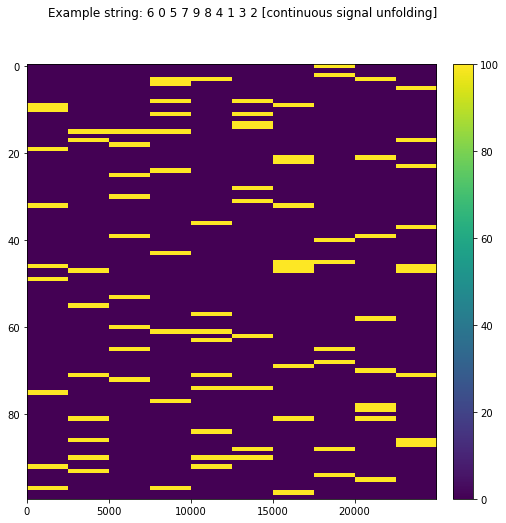

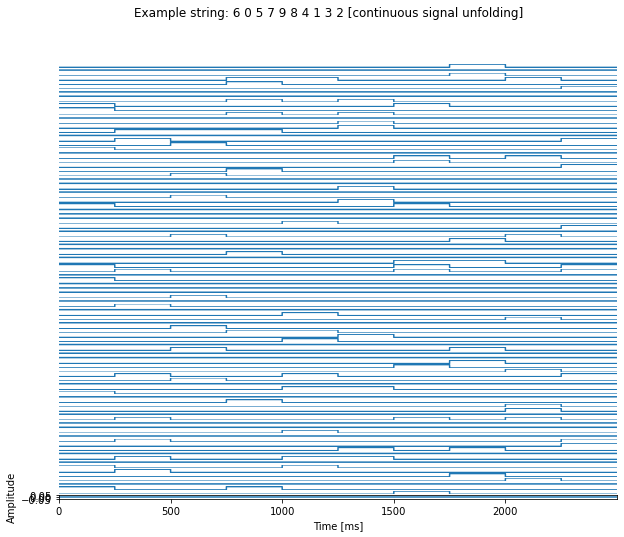

In [11]:
enc = sig
stim_seq, _ = enc.draw_stimulus_sequence(sequence, onset_time=0.1, continuous=continuous, intervals=None)

enc.plot_sample(sequence[:10], continuous=True, intervals=None, display=True, save=False)

* Create target network (for simplicity, we will use a default BRN):

In [12]:
resolution = 0.1
example_defaults.reset_kernel(resolution=resolution, data_label='encoding_test')

In [13]:
# target network
snn, snn_recurrent_connections = example_defaults.default_network(N=100, record_spikes=True)

[snn_network.py:83 - INFO] Initializing Brunel BRN architecture (NEST-simulated)
[snn_network.py:157 - INFO] Creating populations:
[snn_network.py:149 - INFO] - Population E, with ids [1-80]
[snn_network.py:149 - INFO] - Population I, with ids [81-100]
[snn_network.py:474 - INFO] Connecting Devices: 
[base.py:161 - INFO]   - Attaching spike_detector with gid [(101,)] to population E
[snn_network.py:495 - INFO] - Connecting spike_detector to E, with label E_spike_detector and id (101,)
[base.py:161 - INFO]   - Attaching spike_detector with gid [(102,)] to population I
[snn_network.py:495 - INFO] - Connecting spike_detector to I, with label I_spike_detector and id (102,)
[snn_network.py:179 - INFO] Initializing state variables:
[base.py:127 - INFO] - Randomizing V_m state in Population E
[base.py:127 - INFO] - Randomizing V_m state in Population I
[snn_network.py:1137 - INFO] ========================================================
[snn_network.py:1138 - INFO]  Brunel BRN architecture (N

------------

# **6. Delivering inputs to networks - stimulus encodings** <a id='section6'></a>

* Stimuli are provided in `batches` comprising sequences of length $T$.
* SNNs are a special case, as the input needs to be delivered in specific forms and requires the use of NEST generator devices.

# 6.1. `NESTEncoder` <a id='section6.1'></a>
Using SNNs is a very special case.

In [14]:
from fna.encoders import NESTEncoder, InputMapper

In [15]:
# 1) Spike generator
spk_encoder = NESTEncoder('spike_generator', stim_seq=stim_seq, label='spike-pattern-input', input_resolution=enc.dt,
                        dim=emb.embedding_dimensions)
spk_encoder.add_parrots(dt=resolution)

[nest_encoder.py:33 - INFO] Creating Generators: 
[nest_encoder.py:36 - INFO] - spike-pattern-input [(103,)-(202,)]
[nest_encoder.py:43 - INFO] Creating input parrots for spike-pattern-input:
[nest_encoder.py:75 - INFO] - Population spike-pattern-input-parrots, with ids [203-302]
[base.py:161 - INFO]   - Attaching spike_detector with gid [(303,)] to population input-parrots


In [16]:
# 2) DC current
dc_encoder = NESTEncoder('step_current_generator', stim_seq=stim_seq, label='dc-input', input_resolution=enc.dt,
                        dim=emb.embedding_dimensions)

[nest_encoder.py:33 - INFO] Creating Generators: 
[nest_encoder.py:36 - INFO] - dc-input [(304,)-(403,)]


In [17]:
# 3) inhomogeneous Poisson generator
poisson_encoder = NESTEncoder('inhomogeneous_poisson_generator', stim_seq=stim_seq, label='poisson-input', input_resolution=enc.dt,
                        dim=emb.embedding_dimensions)
poisson_encoder.add_parrots(dt=resolution)

[nest_encoder.py:33 - INFO] Creating Generators: 
[nest_encoder.py:36 - INFO] - poisson-input [(404,)-(503,)]
[nest_encoder.py:43 - INFO] Creating input parrots for poisson-input:
[nest_encoder.py:75 - INFO] - Population poisson-input-parrots, with ids [504-603]
[base.py:161 - INFO]   - Attaching spike_detector with gid [(604,)] to population input-parrots


**Note:** The choice of device depends on the signal type. For example, a `spike_generator` can only be used if the input signal are spikes, whereas a `step_current_generator` or an `inhomogeneous_poisson_generator` can only be used if the input is a continuous signal.

* Choose generator 

In [18]:
gen = poisson_encoder

* Connect encoders

In [19]:
# input synapses
input_syn = {'model': 'static_synapse', 'delay': 0.1, 'weight': 10.}
input_conn = {'rule': 'all_to_all'}

input_synapses = {
    'connect_populations': [('E', gen.name), ('I', gen.name),],
    'weight_matrix': [None, None],
    'conn_specs': [input_conn, input_conn],
    'syn_specs': [input_syn, input_syn]
}
in_to_snn_connections = InputMapper(source=gen, target=snn, parameters=input_synapses)

[__init__.py:116 - INFO] Connecting input generators: poisson-input -> Brunel BRN
[__init__.py:127 - INFO]     - ('E', 'poisson-input') [static_synapse]
[__init__.py:127 - INFO]     - ('I', 'poisson-input') [static_synapse]


* Simulate and plot

In [20]:
if continuous:
    snn.simulate(np.round(stim_seq.t_stop)+resolution)

else:
    for t in stim_seq: 
        gen.update_state(t, ids_to_update=list(t.id_list()))
        snn.simulate(t.t_stop - t.t_start)

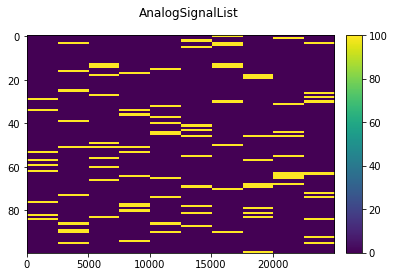

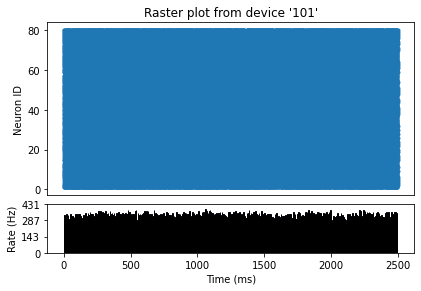

In [21]:
import nest.raster_plot
from fna.tools.signals.spikes import SpikeList

if continuous:
    inp = stim_seq
    if isinstance(inp, SpikeList):
        inp.raster_plot(with_rate=True)
    else:
        inp.plot(as_array=True)

nest.raster_plot.from_device(snn.device_gids[0][0])

## 1.1. `NEF`-style encoding

* Create Encoding SNN instance (do not connect)
* Create `NESTEncoder` and connect to encoding SNN
* Connect encoding SNN to main SNN

In [19]:
from fna.networks.snn import SpikingNetwork
from fna.tools.network_architect.connectivity import NESTConnector

# Encoder SNN
# network parameters
N_enc = 1000
neuron_params = example_defaults.default_neuron_parameters(default_set=0)  # for convenience (full parameters can be passed)
snn_parameters = {
        'populations': ['Enc'],
        'population_size': [N_enc],
        'neurons': [neuron_params],
        'randomize': [{'V_m': (np.random.uniform, {'low': neuron_params['E_L'], 'high': neuron_params['V_th']})}]}
enc_snn = SpikingNetwork(snn_parameters, label='NEF encoder')

# input to encoder synapses
input_synapses = {
    'connect_populations': [('Enc', gen.name)],
    'weight_matrix': [None],
    'conn_specs': [{'rule': 'all_to_all'}],
    'syn_specs': [{'model': 'static_synapse', 'delay': 0.1, 'weight': 10.}]
}
in_to_nef = InputMapper(source=gen, target=enc_snn, parameters=input_synapses)

# encoder to SNN
snn_synapses = {
        'connect_populations': [('E', 'Enc'), ('I', 'Enc')],
        'weight_matrix': [None, None],
        'conn_specs': [{'rule': 'fixed_indegree', 'indegree': 100}, {'rule': 'fixed_indegree', 'indegree': 100}],
        'syn_specs': [{'model': 'static_synapse', 'delay': 1.5, 'weight': 10.}, {'model': 'static_synapse', 'delay': 1.5, 'weight': 10.}]
    }
nef_connections = NESTConnector(source_network=enc_snn, target_network=snn, connection_parameters=snn_synapses)

[snn_network.py:83 - INFO] Initializing NEF encoder architecture (NEST-simulated)
[snn_network.py:157 - INFO] Creating populations:
[snn_network.py:149 - INFO] - Population Enc, with ids [605-1604]
[snn_network.py:474 - INFO] Connecting Devices: 
[snn_network.py:179 - INFO] Initializing state variables:
[base.py:127 - INFO] - Randomizing V_m state in Population Enc
[snn_network.py:1137 - INFO] ========================================================
[snn_network.py:1138 - INFO]  NEF encoder architecture (NEST-simulated):
[snn_network.py:1139 - INFO] --------------------------------------------------------
[snn_network.py:1140 - INFO] - 1 Populations: ['Enc']
[snn_network.py:1141 - INFO] - Size: 1000 [1000]
[snn_network.py:1143 - INFO] - Neuron models: ['iaf_psc_delta']
[snn_network.py:1144 - INFO] - [0] Devices connected: [[]]
[snn_network.py:1146 - INFO]     Enc: [], []
[input_mapper.py:35 - INFO] Connecting input generators: poisson-input -> NEF encoder
[input_mapper.py:46 - INFO]   